In [51]:
import glob
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import cv2



In [52]:
def set_axis(x: np.ndarray, no_labels: int = 7)->tuple[np.ndarray, np.ndarray]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def automedian(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
    img_O = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_CO = cv2.morphologyEx(img_O, cv2.MORPH_CLOSE, struct)
    img_OCO = cv2.morphologyEx(img_CO, cv2.MORPH_OPEN, struct)

    img_C = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_OC = cv2.morphologyEx(img_C, cv2.MORPH_OPEN, struct)
    img_COC = cv2.morphologyEx(img_OC, cv2.MORPH_CLOSE, struct)
    img_Q = np.minimum(img, img_COC)

    img_A = np.maximum(img_Q, img_OCO)

    return img_A

def plt_imshow(df: pd.DataFrame, lines=None, norm=None):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    cax = fig.add_axes((ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height))
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    im = ax.imshow(df,interpolation='none',aspect='auto', norm=norm)
    plt.colorbar(im, cax=cax)
    # if lines is not None:
    #     for line in lines:
    #         rho, theta = line[0]
    #         a = np.cos(theta)
    #         b = np.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho

    #         # Two points far apart that define the line
    #         x1 = int(x0 + 1000 * (-b))
    #         y1 = int(y0 + 1000 * (a))
    #         x2 = int(x0 - 1000 * (-b))
    #         y2 = int(y0 - 1000 * (a))

    #         ax.plot([x1, x2], [y1, y2], color='red', linewidth=2, transform=ax.transData)
    plt.ylabel('time')
    plt.xlabel('space [m]')

In [53]:
path_out = 'train_data/'
files = glob.glob(path_out+"*")
files.sort()

In [54]:
dx = 5.106500953873407
dt = 0.0016

data = []
my_first_filename = 'train_data/091222.npy'
first_id = 0
for idx, filename in enumerate(files):
    if filename == my_first_filename:
        first_id = idx
first_filename = files[first_id]
for file in files[first_id:first_id+12]:
    print(file)
    data.append(np.load(file))
data = np.concatenate(data).astype(np.float32)
time_start = datetime.datetime.strptime(
    '2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

df = pd.DataFrame(data=data, index=index, columns=columns)



train_data/091222.npy
train_data/091232.npy
train_data/091242.npy
train_data/091252.npy
train_data/091302.npy
train_data/091312.npy
train_data/091322.npy
train_data/091332.npy
train_data/091342.npy
train_data/091352.npy
train_data/091402.npy
train_data/091412.npy


In [55]:
# data = np.clip(data, low, high).astype(np.float32)
print(data.shape)
data -= np.mean(data)
data = np.abs(data) 
data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
data = cv2.bilateralFilter(data, 9, 100, 100) #https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

# data = cv2.resize(data, (1000, data.shape[0]), interpolation=cv2.INTER_CUBIC)
_, th = cv2.threshold(data, 0, 255, cv2.THRESH_OTSU)
th[th > 0] = 255
edges = cv2.Canny(th, 5, 20)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)
# edges = cv2.Canny(data_8bit, threshold1=50, threshold2=150, L2gradient=True)

low, high = np.percentile(data, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)
df_processed = pd.DataFrame(data, index=df.index, columns=df.columns)


(75000, 52)


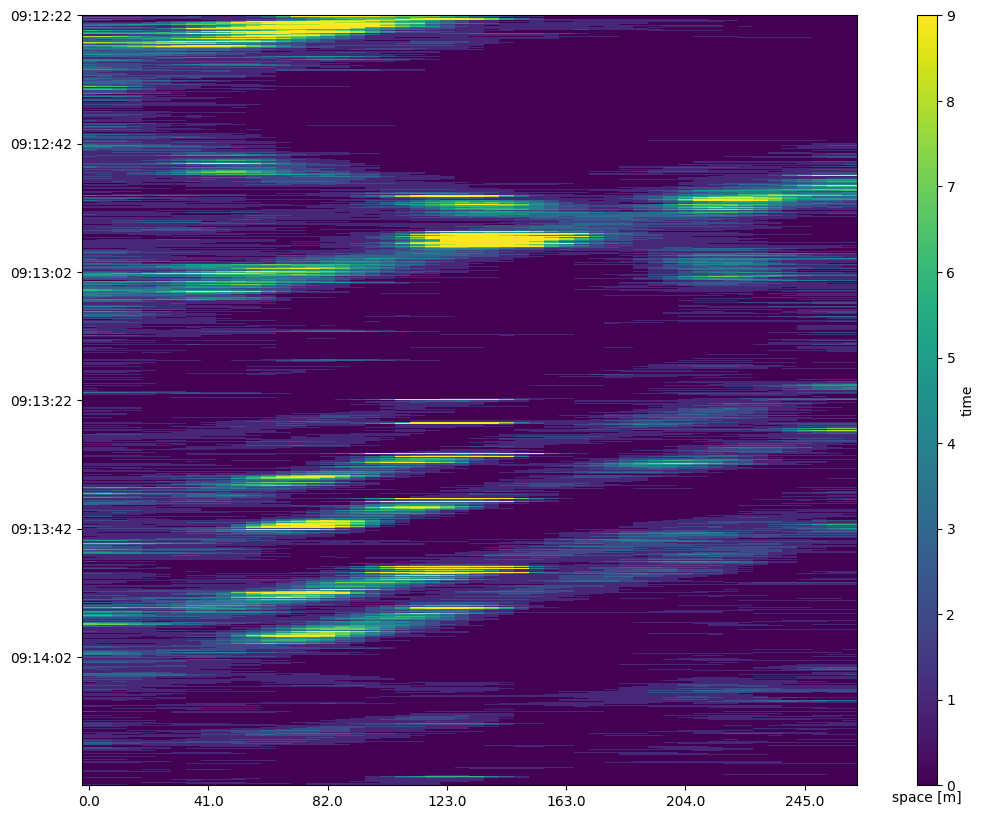

In [56]:
plt_imshow(df_processed, lines=lines, norm=norm)

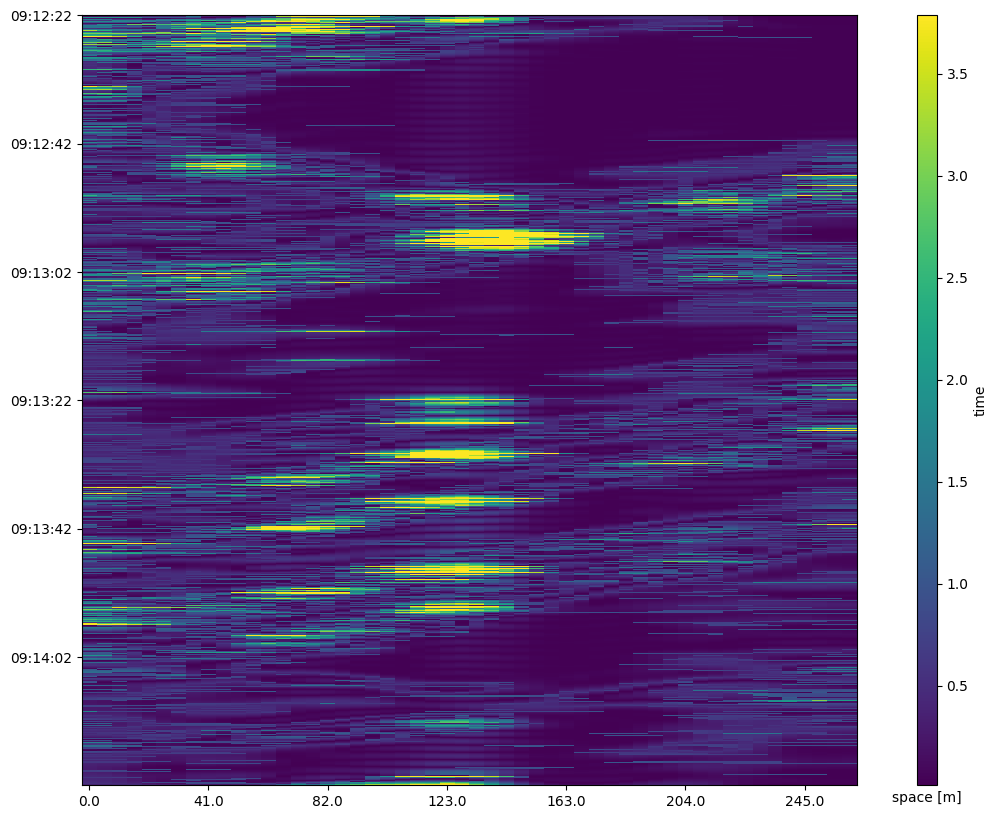

In [57]:
f = np.fft.fft2(data)
fshift = np.fft.fftshift(f)

magnitude = np.log(1 + np.abs(fshift))

# 2️⃣ Create a mask to remove horizontal frequencies (vertical stripes)
rows, cols = data.shape
mask = np.ones((rows, cols), np.uint8)

# Define a horizontal band around the center to block
band_thickness = 50  # tune this based on stripe width
mid_row = rows // 2
mask[mid_row - band_thickness:mid_row + band_thickness, :] = 0

# Apply mask
fshift_filtered = fshift * mask

# 3️⃣ Inverse FFT
f_ishift = np.fft.ifftshift(fshift_filtered)
img_filtered = np.abs(np.fft.ifft2(f_ishift))

# Normalize result
# img_filtered = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX)
low, high = np.percentile(img_filtered, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)
df_filtered = pd.DataFrame(img_filtered, index=df.index, columns=df.columns)

plt_imshow(df_filtered, norm=norm)


In [58]:
#https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv possibly interesting
# https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html